The unknown temperature units
================================

Writing a simple gradient descent code by hand. 

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_printoptions(edgeitems=2, linewidth=75)

## Data

In [3]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

Text(0, 0.5, 'T (unknown)')

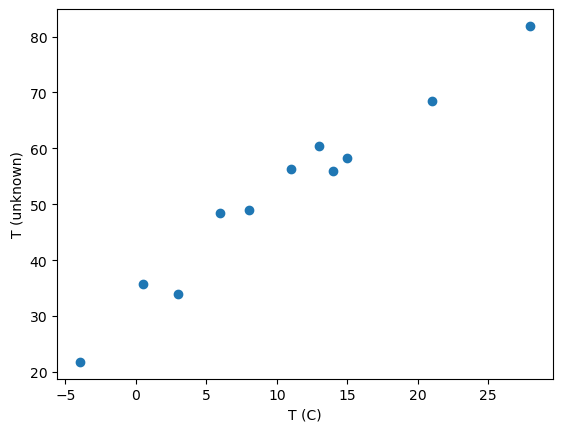

In [4]:
plt.plot(t_c, t_u, 'o')
plt.xlabel("T (C)")
plt.ylabel("T (unknown)")

## Define model and loss

- `w`: weight
- `b`: bias

In [5]:
def model(t_u, w, b):
    return w * t_u + b

In [6]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

## Check model and loss

Initialize parameters

In [7]:
w = torch.ones(())
b = torch.zeros(())

In [8]:
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000,
        21.8000, 48.4000, 60.4000, 68.4000])

In [9]:
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

## Broadcasting example

In [10]:
x = torch.ones(())
y = torch.ones(3,1)
z = torch.ones(1,3)
a = torch.ones(2, 1, 1)
print(f"shapes: x: {x.shape}, y: {y.shape}")
print(f"        z: {z.shape}, a: {a.shape}")
print("x * y:", (x * y).shape)
print("y * z:", (y * z).shape)
print("y * z * a:", (y * z * a).shape)

shapes: x: torch.Size([]), y: torch.Size([3, 1])
        z: torch.Size([1, 3]), a: torch.Size([2, 1, 1])
x * y: torch.Size([3, 1])
y * z: torch.Size([3, 3])
y * z * a: torch.Size([2, 3, 3])


## Gradient descent

### Crude version 

In [11]:
delta = 0.1

loss_rate_of_change_w = \
    (loss_fn(model(t_u, w + delta, b), t_c) - 
     loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [12]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [13]:
loss_rate_of_change_b = \
    (loss_fn(model(t_u, w, b + delta), t_c) - 
     loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

### Improved version

#### Gradient

Defining the derivatives gradients analytically.

Derivative of the loss $\mathcal{L}$ wrt model $m$: $\partial \mathcal{L}/\partial m$

In [14]:
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0)  # <1>
    return dsq_diffs

Derivative of the model $m$ wrt parameters: $\partial m/\partial \theta$.

In [15]:
def dmodel_dw(t_u, w, b):
    return t_u

In [16]:
def dmodel_db(t_u, w, b):
    return 1.0

Gradient of loss:
$$\nabla \mathcal{L} = \left( \frac{\partial \mathcal{L}}{\partial w}, \frac{\partial \mathcal{L}}{\partial b} \right) = \left( \frac{\partial \mathcal{L}}{\partial m} \frac{\partial m}{\partial w}, \frac{\partial \mathcal{L}}{\partial m} \frac{\partial m}{\partial b} \right) $$

In [17]:
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()])  # <1>

#### Training loop

Simplified version

In [18]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        # forward pass
        t_p = model(t_u, w, b)  # <1>
        loss = loss_fn(t_p, t_c)
        # backward pass
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2>

        params = params - learning_rate * grad

        # logging line
        print('Epoch %d, Loss %f' % (epoch, float(loss))) # <3>
            
    return params

Actual version used for training

In [19]:
from tqdm import tqdm

In [20]:
def training_loop(n_epochs, learning_rate, params, t_u, t_c,
                  print_params=True):
    for epoch in tqdm(range(1, n_epochs + 1)):
        w, b = params

        t_p = model(t_u, w, b)  # <1> forward pass
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b)  # <2> backward pass

        params = params - learning_rate * grad

        if epoch in {1, 2, 3, 10, 11, 99, 100, 4000, 5000}:  # <3> logging
            print('Epoch %d, Loss %f' % (epoch, float(loss)))
            if print_params:
                print('    Params:', params)
                print('    Grad:  ', grad)
        if epoch in {4, 12, 101}:
            print('...')

        if not torch.isfinite(loss).all():
            break  # <3>
            
    return params

## Training

Start training loop

In [21]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

 10%|████                                     | 10/100 [00:00<00:00, 2428.95it/s]

Epoch 1, Loss 1763.884766
    Params: tensor([-44.1730,  -0.8260])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
    Params: tensor([2568.4011,   45.1637])
    Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
    Params: tensor([-148527.7344,   -2616.3931])
    Grad:   tensor([15109614.0000,   266155.6875])
...
Epoch 10, Loss 90901105189019073810297959556841472.000000
    Params: tensor([3.2144e+17, 5.6621e+15])
    Grad:   tensor([-3.2700e+19, -5.7600e+17])
Epoch 11, Loss inf
    Params: tensor([-1.8590e+19, -3.2746e+17])
    Grad:   tensor([1.8912e+21, 3.3313e+19])


tensor([-1.8590e+19, -3.2746e+17])

Result: training blew up above, loss $\rightarrow \infty$.

Need to decrease the learning rate, because of diverging optimization (cf. Figure 5.8).

In [22]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-4, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_u, 
    t_c = t_c)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 13997.81it/s]

Epoch 1, Loss 1763.884766
    Params: tensor([ 0.5483, -0.0083])
    Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
    Params: tensor([ 0.3623, -0.0118])
    Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
    Params: tensor([ 0.2858, -0.0135])
    Grad:   tensor([765.4666,  16.5122])
...
Epoch 10, Loss 29.105247
    Params: tensor([ 0.2324, -0.0166])
    Grad:   tensor([1.4803, 3.0544])
Epoch 11, Loss 29.104168
    Params: tensor([ 0.2323, -0.0169])
    Grad:   tensor([0.5781, 3.0384])
...
Epoch 99, Loss 29.023582
    Params: tensor([ 0.2327, -0.0435])
    Grad:   tensor([-0.0533,  3.0226])
Epoch 100, Loss 29.022667
    Params: tensor([ 0.2327, -0.0438])
    Grad:   tensor([-0.0532,  3.0226])


tensor([ 0.2327, -0.0438])

Result: things improve, but gradient stalls. 

Change input scale such that different components of gradient are comparable

In [23]:
t_un = 0.1 * t_u

In [24]:
training_loop(
    n_epochs = 100, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, # <1>
    t_c = t_c)

100%|███████████████████████████████████████| 100/100 [00:00<00:00, 13908.23it/s]

Epoch 1, Loss 80.364342
    Params: tensor([1.7761, 0.1064])
    Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
    Params: tensor([2.0848, 0.1303])
    Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
    Params: tensor([2.2094, 0.1217])
    Grad:   tensor([-12.4631,   0.8587])
...
Epoch 10, Loss 29.030489
    Params: tensor([ 2.3232, -0.0710])
    Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
    Params: tensor([ 2.3284, -0.1003])
    Grad:   tensor([-0.5240,  2.9264])
...
Epoch 99, Loss 22.214186
    Params: tensor([ 2.7508, -2.4910])
    Grad:   tensor([-0.4453,  2.5208])
Epoch 100, Loss 22.148710
    Params: tensor([ 2.7553, -2.5162])
    Grad:   tensor([-0.4446,  2.5165])


tensor([ 2.7553, -2.5162])

Lesson: normalization is an easy and effective way to improve model convergence.

In [25]:
params = training_loop(
    n_epochs = 5000, 
    learning_rate = 1e-2, 
    params = torch.tensor([1.0, 0.0]), 
    t_u = t_un, 
    t_c = t_c,
    print_params = False)

params

  0%|                                                   | 0/5000 [00:00<?, ?it/s]

Epoch 1, Loss 80.364342
Epoch 2, Loss 37.574913
Epoch 3, Loss 30.871077
...
Epoch 10, Loss 29.030489
Epoch 11, Loss 28.941877
...
Epoch 99, Loss 22.214186
Epoch 100, Loss 22.148710
...


 50%|██████████████████▌                  | 2508/5000 [00:00<00:00, 25073.75it/s]

Epoch 4000, Loss 2.927680


100%|█████████████████████████████████████| 5000/5000 [00:00<00:00, 24566.02it/s]

Epoch 5000, Loss 2.927648


tensor([  5.3671, -17.3012])

Parameter we've got: `w = 5.3671, b=-17.3012`

## Results

Celsius to Fahrenheit conversion: `w = 5.5556, b=-17.7778`

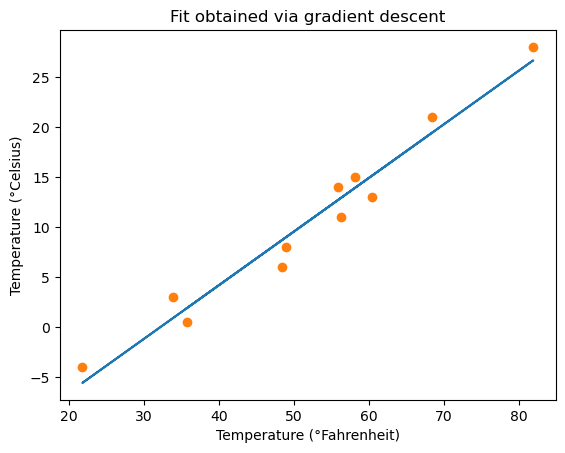

In [26]:
t_p = model(t_un, *params)  # <1>

#fig = plt.figure(dpi=600)
plt.title('Fit obtained via gradient descent')
plt.xlabel("Temperature (°Fahrenheit)")
plt.ylabel("Temperature (°Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # <2>
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
#plt.savefig("temp_unknown_plot.png", format="png")  # bookskip